# Imports

In [29]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: model selection
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    cross_val_score,
    GridSearchCV
)

# Scikit-learn: preprocessing & pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Scikit-learn: models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Scikit-learn: metrics & utilities
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    mean_squared_error,
    classification_report
)
from sklearn.base import clone

# Orginal Code


## LDA

In [30]:
# # -------------------------
# # 1) Load + preprocess data
# # -------------------------
# df = pd.read_csv("data/titanic_augmented.csv")

# drop_cols = ["PassengerId", "Name", "Ticket", "Cabin", "booking_reference", "service_id", "title",
#              "SibSp", "Parch", "is_alone", "fare_per_person", "age_fare_ratio", "cabin_room_number",
#              "name_length", "name_word_count"
#              ]
# df = df.drop(columns=drop_cols)


# # Train/Test split (25% test)
# X = df.drop(columns=["Survived"])
# y = df["Survived"]

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25,
#     random_state=42,
#     stratify=y
# )

# # Impute missing values

# age_medians = X_train.groupby("Pclass")["Age"].median()
# embarked_mode = X_train["Embarked"].mode()[0]

# X_train["Age"] = X_train["Age"].fillna(X_train["Pclass"].map(age_medians))
# X_test["Age"]  = X_test["Age"].fillna(X_test["Pclass"].map(age_medians))

# X_train["Embarked"] = X_train["Embarked"].fillna(embarked_mode)
# X_test["Embarked"]  = X_test["Embarked"].fillna(embarked_mode)


# # One-hot encode categoricals
# X_train = pd.get_dummies(
#     X_train,
#     columns=["Sex", "Embarked", "title_group", "cabin_deck"],
#     drop_first=True
# )

# X_test = pd.get_dummies(
#     X_test,
#     columns=["Sex", "Embarked", "title_group", "cabin_deck"],
#     drop_first=True
# )
# X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)
# fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# for i, pclass in enumerate(sorted(X_train["Pclass"].unique())):
#     axes[i].hist(
#         X_train[X_train["Pclass"] == pclass]["Age"],
#         bins=30,
#         alpha=0.7
#     )
#     axes[i].set_title(f"Pclass {pclass}")
#     axes[i].set_xlabel("Age")
#     if i == 0:
#         axes[i].set_ylabel("Frequency")

# fig.suptitle("Age Distribution by Passenger Class", y=1.05)
# plt.tight_layout()
# plt.show()
# df.groupby("Pclass")["Age"].median()
# # -------------------------
# # 2) Resampling setup (CV on TRAIN only)
# # -------------------------
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# # -------------------------
# # 3) Baseline LDA model (no tuning)
# # -------------------------
# baseline_pipeline = Pipeline([
#     ("scaler", StandardScaler()),
#     ("lda", LinearDiscriminantAnalysis())  # default solver='svd'
# ])

# cv_scores_baseline = cross_val_score(
#     baseline_pipeline, X_train, y_train,
#     cv=cv, scoring="accuracy"
# )

# print("=== Baseline LDA (TRAIN CV) ===")
# print(f"CV Accuracy: mean={cv_scores_baseline.mean():.4f}, std={cv_scores_baseline.std():.4f}")

# # Fit on TRAIN, evaluate on TEST
# baseline_pipeline.fit(X_train, y_train)
# y_pred_test = baseline_pipeline.predict(X_test)

# print("\n=== Baseline LDA (TEST holdout) ===")
# print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
# print(f"Test MSE:      {mean_squared_error(y_test, y_pred_test):.4f}")
# print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_test))

# coefs_baseline = []
# for tr_idx, va_idx in cv.split(X_train, y_train):
#     X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
#     m = clone(baseline_pipeline)
#     m.fit(X_tr, y_tr)
#     coefs_baseline.append(m.named_steps["lda"].coef_.ravel())

# coefs_baseline = np.vstack(coefs_baseline)

# importance_baseline = pd.DataFrame({
#     "mean_coef": np.mean(coefs_baseline, axis=0),
#     "mean_abs_coef": np.mean(np.abs(coefs_baseline), axis=0),
#     "std_abs_coef":  np.std(np.abs(coefs_baseline), axis=0)
# }, index=X_train.columns).sort_values("mean_abs_coef", ascending=False)

# print("\n=== Top 15 Features (LDA Baseline) ===")
# print(importance_baseline.head(15))

# lda_scores_baseline = baseline_pipeline.decision_function(X_test)

# plt.figure()
# plt.hist(lda_scores_baseline[y_test == 0], bins=15, alpha=0.7, label="Died")
# plt.hist(lda_scores_baseline[y_test == 1], bins=15, alpha=0.7, label="Survived")
# plt.xlabel("LDA discriminant score")
# plt.ylabel("Frequency")
# plt.title("LDA Baseline Model")
# plt.legend()
# plt.show()

# top_n = 15
# top = importance_baseline.head(top_n)

# plt.figure(figsize=(8, 6))
# plt.barh(top.index[::-1], top["mean_abs_coef"][::-1])
# plt.xlabel("Mean |LDA coefficient| (CV-averaged)")
# plt.title(f"Top {top_n} Feature Importances (Baseline LDA)")
# plt.tight_layout()
# plt.show()

# cm = confusion_matrix(y_test, y_pred_test)

# # Plot
# plt.figure(figsize=(5, 4))
# sns.heatmap(
#     cm,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=["Died", "Survived"],
#     yticklabels=["Died", "Survived"]
# )

# plt.xlabel("Predicted label")
# plt.ylabel("True label")
# plt.title("Confusion Matrix – Baseline LDA")
# plt.tight_layout()
# plt.show()

# # -------------------------
# # 4) Hyperparameter tuning (TRAIN only) - solver + shrinkage
# #    Note: shrinkage applies to lsqr (not svd).
# # -------------------------
# tuned_pipeline = Pipeline([
#     ("scaler", StandardScaler()),
#     ("lda", LinearDiscriminantAnalysis())
# ])
# shrink_grid = ["auto"] + list(np.linspace(0, 1, 21))
# param_grid = [
#     {"lda__solver": ["svd"]},  
#     {"lda__solver": ["lsqr"], "lda__shrinkage": shrink_grid}
# ]

# grid = GridSearchCV(
#     tuned_pipeline,
#     param_grid=param_grid,
#     cv=cv,
#     scoring="accuracy",
#     n_jobs=1  # keep 1 for reliability in some notebook environments
# )

# grid.fit(X_train, y_train)

# print("\n=== Tuned LDA (TRAIN CV via GridSearchCV) ===")
# print("Best params:", grid.best_params_)
# print(f"Best CV Accuracy: {grid.best_score_:.4f}")

# best_model = grid.best_estimator_

# # Evaluate best tuned model on TEST
# y_pred_test_tuned = best_model.predict(X_test)
# print("\n=== Tuned LDA (TEST holdout) ===")
# print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test_tuned):.4f}")
# print(f"Test MSE:      {mean_squared_error(y_test, y_pred_test_tuned):.4f}")
# print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_test_tuned))

# # -------------------------
# # 5) Feature importance (TRAIN only) using CV-averaged |coefficients|
# #    Use a stable LDA config (often shrinkage helps)
# # -------------------------
# importance_pipeline = Pipeline([
#     ("scaler", StandardScaler()),
#     ("lda", LinearDiscriminantAnalysis(solver="lsqr", shrinkage=0.1))
# ])

# coefs_best_tuned = []
# for tr_idx, va_idx in cv.split(X_train, y_train):
#     X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
#     m = clone(importance_pipeline)
#     m.fit(X_tr, y_tr)
#     coefs_best_tuned.append(m.named_steps["lda"].coef_.ravel())

# coefs_best_tuned = np.vstack(coefs_best_tuned)

# importance_best_tuned = pd.DataFrame({
#     "mean_coef": np.mean(coefs_best_tuned, axis=0),
#     "mean_abs_coef": np.mean(np.abs(coefs_best_tuned), axis=0),
#     "std_abs_coef":  np.std(np.abs(coefs_best_tuned), axis=0)
# }, index=X_train.columns).sort_values("mean_abs_coef", ascending=False)

# print("\n=== Top 15 Features (LDA Best Tuned) ===")
# print(importance_best_tuned.head(15))

# # -------------------------
# # 6) Feature tuning: choose top-k features by CV on TRAIN only
# # -------------------------
# k_results = []
# for k in range(5, X_train.shape[1] + 1):
#     top_k = importance_best_tuned.head(k).index
#     X_train_k = X_train[top_k]

#     scores_k = cross_val_score(
#         importance_pipeline,
#         X_train_k,
#         y_train,
#         cv=cv,
#         scoring="accuracy"
#     )

#     k_results.append({
#         "k": k,
#         "cv_mean_accuracy": scores_k.mean(),
#         "cv_std_accuracy": scores_k.std()
#     })

# k_results_df = pd.DataFrame(k_results).sort_values("cv_mean_accuracy", ascending=False)
# best_k = int(k_results_df.iloc[0]["k"])

# print("\n=== Feature Tuning Results (TRAIN CV) ===")
# print("Best k by CV mean accuracy:", best_k)
# print(k_results_df)

# # -------------------------
# # 7) Final feature-tuned model: fit on TRAIN, evaluate on TEST
# # -------------------------
# final_features = importance_best_tuned.head(best_k).index
# final_model = Pipeline([
#     ("scaler", StandardScaler()),
#     ("lda", LinearDiscriminantAnalysis(solver="lsqr", shrinkage=0.1))
# ])

# final_model.fit(X_train[final_features], y_train)
# y_pred_final = final_model.predict(X_test[final_features])

# print("\n=== Final Feature-Tuned LDA (TEST holdout) ===")
# print("Using top-k features:", best_k)
# print(f"Test Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
# print(f"Test MSE:      {mean_squared_error(y_test, y_pred_final):.4f}")
# print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_final))

# coefs_best_features = []
# for tr_idx, va_idx in cv.split(X_train, y_train):
#     X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
#     m = clone(final_model)
#     m.fit(X_tr, y_tr)
#     coefs_best_features.append(m.named_steps["lda"].coef_.ravel())

# coefs_best_features = np.vstack(coefs_best_features)

# importance_final = pd.DataFrame({
#     "mean_coef": np.mean(coefs_best_features, axis=0),
#     "mean_abs_coef": np.mean(np.abs(coefs_best_features), axis=0),
#     "std_abs_coef":  np.std(np.abs(coefs_best_features), axis=0)
# }, index=X_train.columns).sort_values("mean_abs_coef", ascending=False)

# print("\n=== Feature Importance (LDA Final Model) ===")
# print(importance_final)

# lda_scores_final= final_model.decision_function(X_test[final_features])

# plt.figure()
# plt.hist(lda_scores_final[y_test == 0], bins=15, alpha=0.7, label="Died")
# plt.hist(lda_scores_final[y_test == 1], bins=15, alpha=0.7, label="Survived")
# plt.xlabel("LDA discriminant score")
# plt.ylabel("Frequency")
# plt.title("LDA Final Model")
# plt.legend()
# plt.show()

# top_n = min(15, len(final_features))
# top = importance_final.head(top_n).sort_values("mean_abs_coef")

# plt.figure(figsize=(8, 6))
# plt.barh(top.index, top["mean_abs_coef"])
# plt.xlabel("Mean |LDA coefficient| (CV-averaged)")
# plt.title("Top Feature Importances – Final Feature-Tuned LDA")
# plt.tight_layout()
# plt.show()

# cm_final = confusion_matrix(y_test, y_pred_final)

# plt.figure(figsize=(5, 4))
# sns.heatmap(
#     cm_final,
#     annot=True,
#     fmt="d",
#     cmap="Blues",
#     xticklabels=["Died", "Survived"],
#     yticklabels=["Died", "Survived"]
# )

# plt.xlabel("Predicted label")
# plt.ylabel("True label")
# plt.title("Confusion Matrix – Final Feature-Tuned LDA")
# plt.tight_layout()
# plt.show()


## Decision Tree, Logistic Regression & KNN

In [31]:
# ogdata = pd.read_csv('data/titanic_augmented.csv')
# ogdata.head()

# #1.Data splitting
# X = ogdata.drop('Survived',axis = 1)
# y = ogdata['Survived']
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state=42,stratify = y)

# #2.Data preprocessing:
# #ogdata.isnull().sum()
# #Imputing missing values
# train_age_median = X_train['Age'].median()
# train_embarked_mode = X_train['Embarked'].mode()[0]
# X_train['Age'] =X_train['Age'].fillna(train_age_median)
# X_test['Age'] =X_test['Age'].fillna(train_age_median)
# X_train['Embarked'] =X_train['Embarked'].fillna(train_embarked_mode)
# X_test['Embarked'] =X_test['Embarked'].fillna(train_embarked_mode)
# # turn object to int
# gender_map = {'female': 1, 'male': 0}
# X_train['Sex'] = X_train['Sex'].map(gender_map)
# X_test['Sex'] = X_test['Sex'].map(gender_map)
# embarked_map = {'S': 0, 'C': 1, 'Q': 2}
# X_train['Embarked'] = X_train['Embarked'].map(embarked_map)
# X_test['Embarked'] = X_test['Embarked'].map(embarked_map)
# #nomalization
# train_fare_mean = X_train['Fare'].mean()
# train_fare_std = X_train['Fare'].std()

# X_train['Fare_Scaled'] = (X_train['Fare'] - train_fare_mean) / train_fare_std

# X_test['Fare_Scaled'] = (X_test['Fare'] - train_fare_mean) / train_fare_std

# train_age_min = X_train['Age'].min()
# train_age_max = X_train['Age'].max()

# X_train['Age_Scaled'] = (X_train['Age'] - train_age_min) / (train_age_max - train_age_min)
# X_test['Age_Scaled'] = (X_test['Age'] - train_age_min) / (train_age_max - train_age_min)

# ogdata.info()

# print(X_train[['Age_Scaled','Fare_Scaled','Sex','Embarked']].head())

# X_train_numeric = X_train.select_dtypes(include=['int64', 'float64'])
# rf_model = RandomForestClassifier(n_estimators=100, random_state = 42)
# rf_model.fit(X_train_numeric,y_train)
# ranking = pd.Series(rf_model.feature_importances_ ,index = X_train_numeric.columns).sort_values(ascending = False)
# print('the ranking is :')

# print(ranking)

# #WE will consider the first 6 variables

# final_features= ['Pclass', 'Sex', 'Age_Scaled',  'fare_per_person', 

#     'name_length','cabin_score']

# X_train_final = X_train[final_features]

# y_train_final = y_train

# #4Model building and training
# print('logistic_models')
# param_grid = {
#     'C':[0.01,0.1,1,10,100],
#     'penalty' : ['l1','l2'],
#     'solver' : ['liblinear']}
# lr = LogisticRegression(random_state=42)
# gridsearch = GridSearchCV(lr,param_grid, cv=5, scoring = 'accuracy')
# gridsearch.fit(X_train_final, y_train)
# print("best param:", gridsearch.best_params_)
# print("best scores:", gridsearch.best_score_)

# print('DecisionTree_models')
# dt_param_grid = {
#     "max_depth":[3,5,7,9,None],
#     "min_samples_leaf":[1,2,5,10],
#     'criterion': ['gini', 'entropy']}
# dt=DecisionTreeClassifier(random_state=42)
# dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5)
# dt_grid.fit(X_train_final, y_train)

# print("best param:", dt_grid.best_params_)
# print("best scores:", dt_grid.best_score_)

# print('KNN')
# knn_param_grid = {
#     'n_neighbors': [3, 5, 7, 9, 11, 15],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan'] 
# }


# knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5)
# knn_grid.fit(X_train_final, y_train)

# print("best param:", knn_grid.best_params_)
# print("best scores:", knn_grid.best_score_)

# #5Hyperparameter tuning
# final_features = ['Pclass', 'Sex', 'Age_Scaled', 'fare_per_person', 'name_length', 'cabin_score']
# X_train_final = X_train[final_features]
# X_test_final = X_test[final_features]

# # Re-fit models
# print("\nRe-training models to match the new feature order...")
# gridsearch.fit(X_train_final, y_train)
# dt_grid.fit(X_train_final, y_train)   
# knn_grid.fit(X_train_final, y_train) 

# best_lr = gridsearch.best_estimator_
# best_dt = dt_grid.best_estimator_
# best_knn = knn_grid.best_estimator_

# final_models = {
#     "Logistic Regression": best_lr, 
#     "Decision Tree": best_dt, 
#     "KNN": best_knn
# }

# test_accuracies = {}

# print("\n--- Final Test Set Evaluation Results ---")
# for name, model in final_models.items():
#     y_pred = model.predict(X_test_final)
#     acc = accuracy_score(y_test, y_pred)
#     test_accuracies[name] = acc
#     print(f"\nModel: {name}")
#     print(f"Test Accuracy: {acc:.4f}")
#     # Reporting detailed metrics as per project requirements
#     print(classification_report(y_test, y_pred))

#     #6esult evaluation and visualization

# # --- Visualization 1: Accuracy Comparison Chart ---
# plt.figure(figsize=(10, 6))
# # Convert results to a Series for easier plotting
# performance_series = pd.Series(test_accuracies).sort_values(ascending=False)

# sns.barplot(x=performance_series.index, y=performance_series.values, palette='viridis')

# # Add values on top of the bars
# for i, v in enumerate(performance_series.values):
#     plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# plt.ylim(0.6, 0.9) # Focus on the relevant accuracy range
# plt.title('Performance Comparison (Accuracy) on Test Set', fontsize=14)
# plt.ylabel('Accuracy Score')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

# # --- Visualization 2: Confusion Matrices ---
# # Visualizing how models are misclassifying (False Positives vs False Negatives)
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# for i, (name, model) in enumerate(final_models.items()):
#     y_pred = model.predict(X_test_final)
#     cm = confusion_matrix(y_test, y_pred)
    
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
#                 xticklabels=['Perished', 'Survived'], 
#                 yticklabels=['Perished', 'Survived'])
#     axes[i].set_title(f'Confusion Matrix: {name}')
#     axes[i].set_xlabel('Predicted Label')
#     axes[i].set_ylabel('True Label')

# plt.tight_layout()
# plt.show()


# two sets of code combined

### with LDA data cleaning

In [32]:
df = pd.read_csv("data/titanic_augmented.csv")

drop_cols = [
    "PassengerId", "Name", "Ticket", "Cabin", "booking_reference", "service_id", "title",
    "SibSp", "Parch", "is_alone", "fare_per_person", "age_fare_ratio", "cabin_room_number",
    "name_length", "name_word_count"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

X = df.drop(columns=["Survived"])
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Impute missing values using TRAIN statistics only
age_medians = X_train.groupby("Pclass")["Age"].median()
embarked_mode = X_train["Embarked"].mode()[0]

X_train.loc[:, "Age"] = X_train["Age"].fillna(X_train["Pclass"].map(age_medians))
X_test.loc[:, "Age"]  = X_test["Age"].fillna(X_test["Pclass"].map(age_medians))

X_train.loc[:, "Embarked"] = X_train["Embarked"].fillna(embarked_mode)
X_test.loc[:, "Embarked"]  = X_test["Embarked"].fillna(embarked_mode)

# One-hot encode categorical columns that exist
cat_cols = [c for c in ["Sex", "Embarked", "title_group", "cabin_deck"] if c in X_train.columns]
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test  = pd.get_dummies(X_test,  columns=cat_cols, drop_first=True)

# Align columns so train/test match
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (668, 21) Test shape: (223, 21)


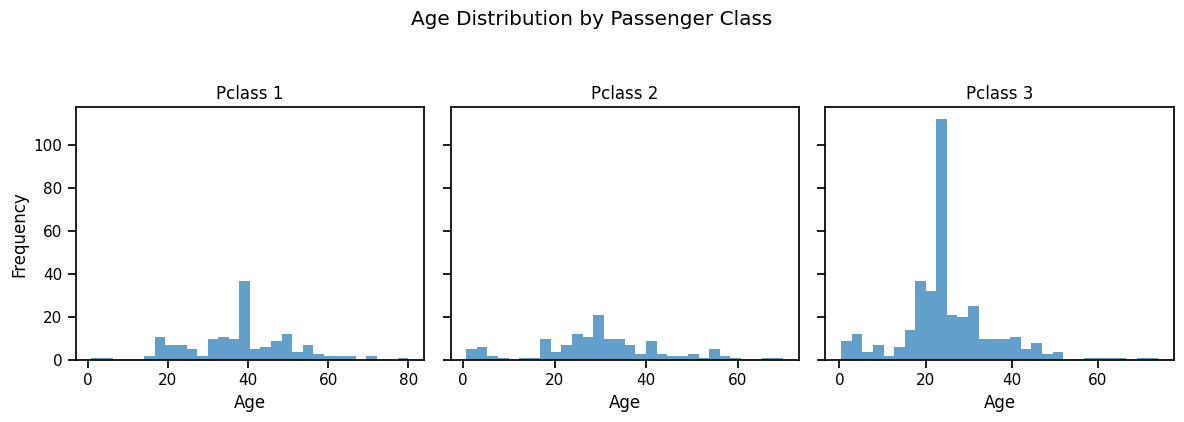

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i, pclass in enumerate(sorted(X_train["Pclass"].unique())):
    axes[i].hist(X_train[X_train["Pclass"] == pclass]["Age"], bins=30, alpha=0.7)
    axes[i].set_title(f"Pclass {pclass}")
    axes[i].set_xlabel("Age")
    if i == 0:
        axes[i].set_ylabel("Frequency")

fig.suptitle("Age Distribution by Passenger Class", y=1.05)
plt.tight_layout()
plt.show()

In [34]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

def evaluate(name, model, X_train, y_train, X_test, y_test, cv):
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "name": name,
        "model": model,
        "cv_mean": cv_scores.mean(),
        "cv_std": cv_scores.std(),
        "test_acc": accuracy_score(y_test, y_pred),
        "test_mse": mean_squared_error(y_test, y_pred),
        "cm": confusion_matrix(y_test, y_pred),
        "y_pred": y_pred
    }

def plot_accuracy_bar(results):
    perf = pd.Series({r["name"]: r["test_acc"] for r in results}).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=perf.index, y=perf.values)
    for i, v in enumerate(perf.values):
        plt.text(i, v + 0.01, f"{v:.4f}", ha="center", fontweight="bold")
    plt.ylim(max(0, perf.min() - 0.1), min(1.0, perf.max() + 0.1))
    plt.title("Performance Comparison (Accuracy) on Test Set")
    plt.ylabel("Accuracy Score")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results):
    n = len(results)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))
    if n == 1:
        axes = [axes]
    for ax, r in zip(axes, results):
        sns.heatmap(r["cm"], annot=True, fmt="d", cmap="Blues", ax=ax,
                    xticklabels=["Died", "Survived"], yticklabels=["Died", "Survived"])
        ax.set_title(f"Confusion Matrix: {r['name']}")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
    plt.tight_layout()
    plt.show()

In [35]:
pipelines = {
    "LDA": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearDiscriminantAnalysis())
    ]),
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000, random_state=42))
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier())
    ]),
    "Decision Tree": Pipeline([
        ("model", DecisionTreeClassifier(random_state=42))
    ])
}

In [36]:
param_grids = {
    "LDA": [
        {"model__solver": ["svd"]},
        {"model__solver": ["lsqr"], "model__shrinkage": ["auto"] + list(np.linspace(0, 1, 21))}
    ],
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10, 100],
        "model__penalty": ["l1", "l2"],
        "model__solver": ["liblinear"]
    },
    "Decision Tree": {
        "model__max_depth": [3, 5, 7, 9, None],
        "model__min_samples_leaf": [1, 2, 5, 10],
        "model__criterion": ["gini", "entropy"]
    },
    "KNN": {
        "model__n_neighbors": [3, 5, 7, 9, 11, 15],
        "model__weights": ["uniform", "distance"],
        "model__metric": ["euclidean", "manhattan"]
    }
}

best_models = {}
for name, pipe in pipelines.items():
    grid = GridSearchCV(
        pipe,
        param_grids[name],
        cv=5,
        scoring="accuracy",
        n_jobs=1
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"\n{name} best params: {grid.best_params_}")
    print(f"{name} best CV score: {grid.best_score_:.4f}")


LDA best params: {'model__shrinkage': 0.1, 'model__solver': 'lsqr'}
LDA best CV score: 0.8249

Logistic Regression best params: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Logistic Regression best CV score: 0.8399

KNN best params: {'model__metric': 'manhattan', 'model__n_neighbors': 7, 'model__weights': 'uniform'}
KNN best CV score: 0.8248

Decision Tree best params: {'model__criterion': 'entropy', 'model__max_depth': 7, 'model__min_samples_leaf': 2}
Decision Tree best CV score: 0.8368


In [37]:
results = []
for name, model in best_models.items():
    r = evaluate(name, model, X_train, y_train, X_test, y_test, cv=cv)
    results.append(r)

    print(f"\n=== {name} (tuned) ===")
    print(f"CV Accuracy: mean={r['cv_mean']:.4f}, std={r['cv_std']:.4f}")
    print(f"Test Accuracy: {r['test_acc']:.4f}")
    print(f"Test MSE:      {r['test_mse']:.4f}")
    print(classification_report(y_test, r["y_pred"]))


=== LDA (tuned) ===
CV Accuracy: mean=0.8264, std=0.0505
Test Accuracy: 0.8072
Test MSE:      0.1928
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       137
           1       0.76      0.73      0.75        86

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.81      0.81      0.81       223


=== Logistic Regression (tuned) ===
CV Accuracy: mean=0.8368, std=0.0465
Test Accuracy: 0.8251
Test MSE:      0.1749
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       137
           1       0.77      0.78      0.77        86

    accuracy                           0.83       223
   macro avg       0.82      0.82      0.82       223
weighted avg       0.83      0.83      0.83       223


=== KNN (tuned) ===
CV Accuracy: mean=0.8234, std=0.0462
Test Accuracy: 0.8027
Test MSE:      0.1973
              precision 

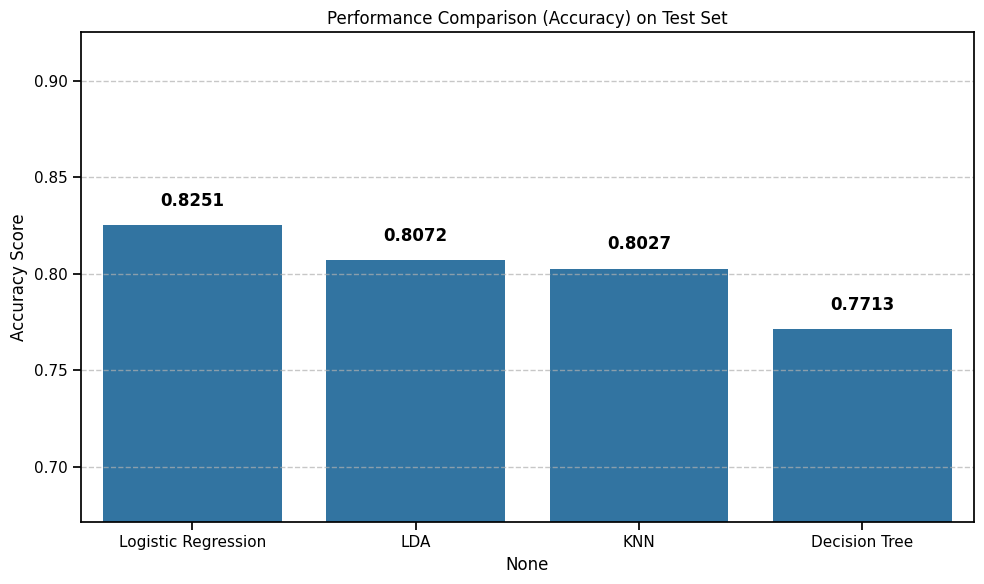

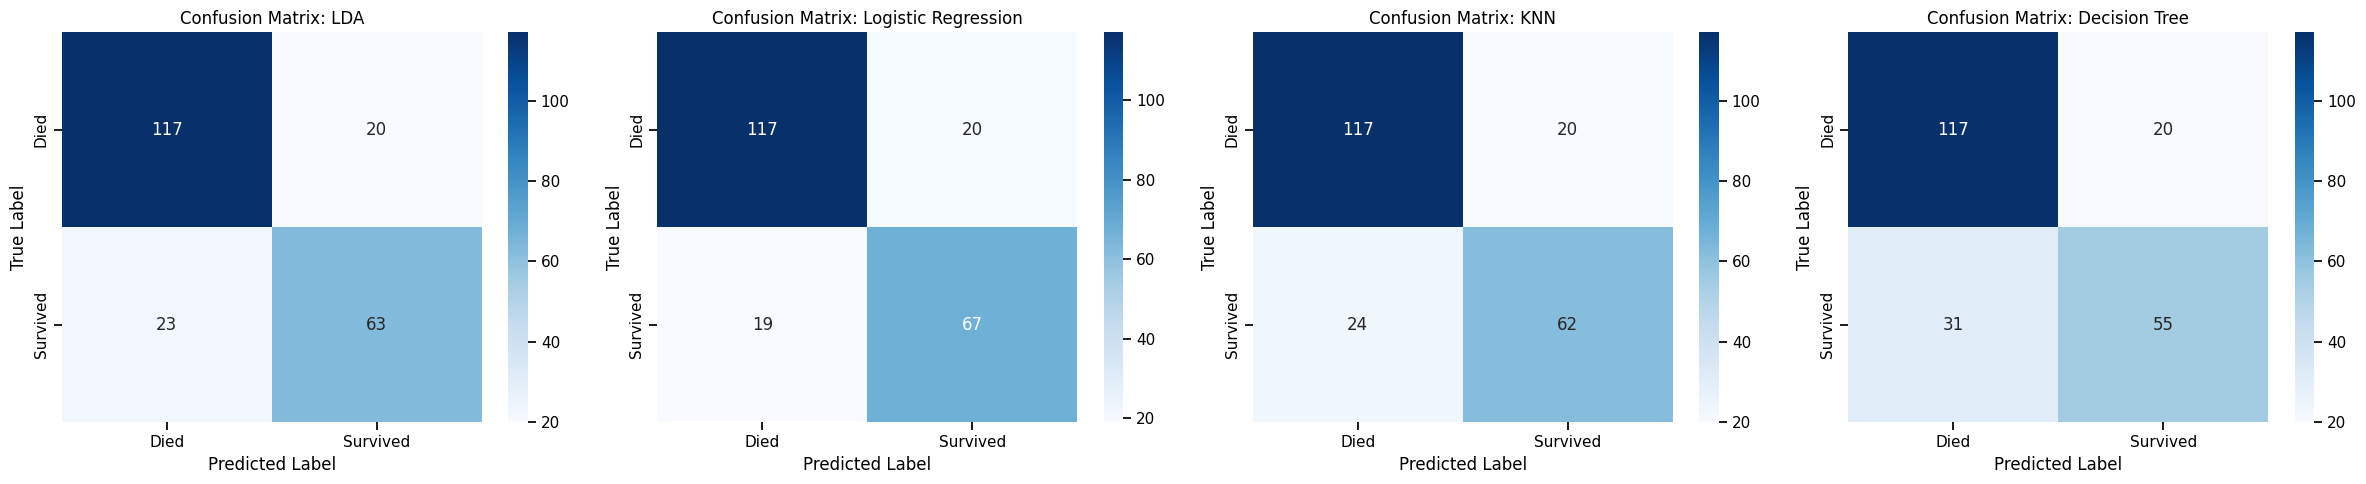

In [38]:
plot_accuracy_bar(results)
plot_confusion_matrices(results)

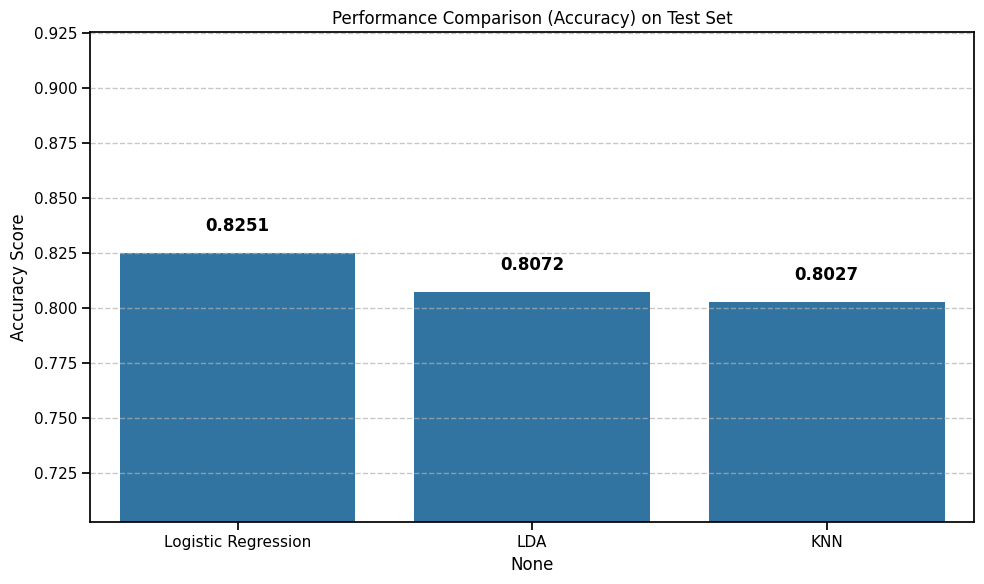

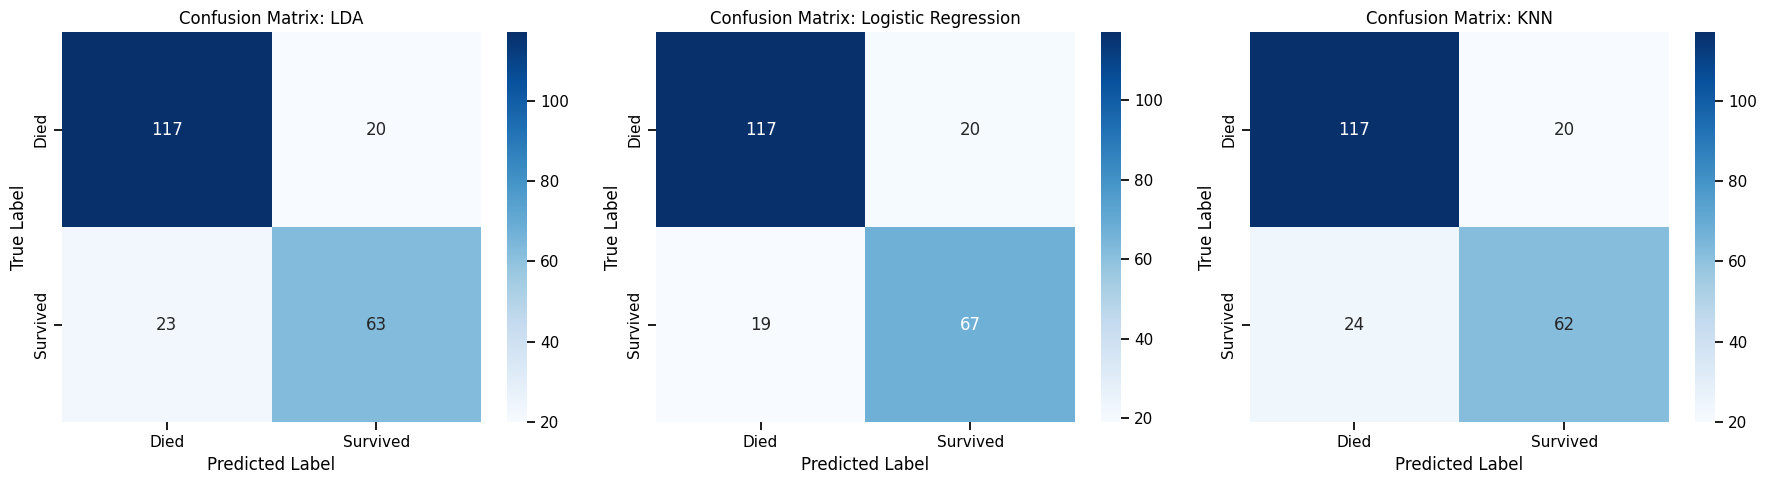

In [39]:
results_no_dt = [r for r in results if r["name"] != "Decision Tree"]

plot_accuracy_bar(results_no_dt)
plot_confusion_matrices(results_no_dt)

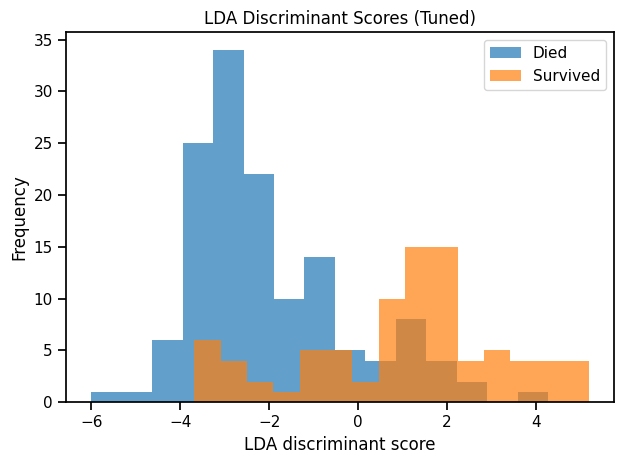

In [42]:
lda_best = best_models["LDA"]
lda_scores = lda_best.decision_function(X_test)

plt.figure()
plt.hist(lda_scores[y_test == 0], bins=15, alpha=0.7, label="Died")
plt.hist(lda_scores[y_test == 1], bins=15, alpha=0.7, label="Survived")
plt.xlabel("LDA discriminant score")
plt.ylabel("Frequency")
plt.title("LDA Discriminant Scores (Tuned)")
plt.legend()
plt.tight_layout()
plt.show()

### with project demo cleaning

In [43]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, GridSearchCV,
    RepeatedStratifiedKFold, cross_val_score
)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import (
    accuracy_score, mean_squared_error,
    confusion_matrix, classification_report
)

sns.set_context("notebook")

In [44]:
df = pd.read_csv("data/titanic_augmented.csv")
df.head()

X = df.drop("Survived", axis=1)
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [45]:
# ---- Imputation (TRAIN stats only) ----
age_median = X_train["Age"].median()
embarked_mode = X_train["Embarked"].mode()[0]

X_train["Age"] = X_train["Age"].fillna(age_median)
X_test["Age"]  = X_test["Age"].fillna(age_median)

X_train["Embarked"] = X_train["Embarked"].fillna(embarked_mode)
X_test["Embarked"]  = X_test["Embarked"].fillna(embarked_mode)

# ---- Encoding ----
gender_map = {"female": 1, "male": 0}
embarked_map = {"S": 0, "C": 1, "Q": 2}

X_train["Sex"] = X_train["Sex"].map(gender_map)
X_test["Sex"]  = X_test["Sex"].map(gender_map)

X_train["Embarked"] = X_train["Embarked"].map(embarked_map)
X_test["Embarked"]  = X_test["Embarked"].map(embarked_map)

# ---- Scaling (manual, TRAIN only) ----
fare_mean = X_train["Fare"].mean()
fare_std  = X_train["Fare"].std()

X_train["Fare_Scaled"] = (X_train["Fare"] - fare_mean) / fare_std
X_test["Fare_Scaled"]  = (X_test["Fare"] - fare_mean) / fare_std

age_min = X_train["Age"].min()
age_max = X_train["Age"].max()

X_train["Age_Scaled"] = (X_train["Age"] - age_min) / (age_max - age_min)
X_test["Age_Scaled"]  = (X_test["Age"] - age_min) / (age_max - age_min)

X_train[["Age_Scaled", "Fare_Scaled", "Sex", "Embarked"]].head()

,Age_Scaled,Fare_Scaled,Sex,Embarked
486,0.434531,1.239468,1,0
238,0.233476,-0.435702,0,0
722,0.421965,-0.383023,0,0
184,0.044986,-0.192855,1,0
56,0.258608,-0.435702,1,0


In [46]:
final_features = [
    "Pclass",
    "Sex",
    "Age_Scaled",
    "fare_per_person",
    "name_length",
    "cabin_score"
]

X_train_final = X_train[final_features].copy()
X_test_final  = X_test[final_features].copy()

In [47]:
lr_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"]
}

lr = LogisticRegression(random_state=42)
lr_gs = GridSearchCV(lr, lr_grid, cv=5, scoring="accuracy")
lr_gs.fit(X_train_final, y_train)

best_lr = lr_gs.best_estimator_
print(lr_gs.best_params_, lr_gs.best_score_)

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'} 0.7994052294916395


In [48]:
dt_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_leaf": [1, 2, 5, 10],
    "criterion": ["gini", "entropy"]
}

dt = DecisionTreeClassifier(random_state=42)
dt_gs = GridSearchCV(dt, dt_grid, cv=5, scoring="accuracy")
dt_gs.fit(X_train_final, y_train)

best_dt = dt_gs.best_estimator_
print(dt_gs.best_params_, dt_gs.best_score_)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 10} 0.8143754909662215


In [49]:
knn_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 15],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

knn = KNeighborsClassifier()
knn_gs = GridSearchCV(knn, knn_grid, cv=5, scoring="accuracy")
knn_gs.fit(X_train_final, y_train)

best_knn = knn_gs.best_estimator_
print(knn_gs.best_params_, knn_gs.best_score_)

{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'} 0.7484794074739086


In [50]:
models = {
    "Logistic Regression": best_lr,
    "Decision Tree": best_dt,
    "KNN": best_knn
}

test_accuracies = {}

for name, model in models.items():
    y_pred = model.predict(X_test_final)
    acc = accuracy_score(y_test, y_pred)
    test_accuracies[name] = acc

    print(f"\n{name}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


Logistic Regression
Accuracy: 0.7848
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       137
           1       0.71      0.74      0.73        86

    accuracy                           0.78       223
   macro avg       0.77      0.78      0.77       223
weighted avg       0.79      0.78      0.79       223


Decision Tree
Accuracy: 0.7892
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       137
           1       0.75      0.67      0.71        86

    accuracy                           0.79       223
   macro avg       0.78      0.77      0.77       223
weighted avg       0.79      0.79      0.79       223


KNN
Accuracy: 0.6861
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       137
           1       0.62      0.49      0.55        86

    accuracy                           0.69       223
   macro avg       0.67      0.65   

In [51]:
cv = RepeatedStratifiedKFold(
    n_splits=10,
    n_repeats=3,
    random_state=42
)

In [52]:
lda_baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())
])

cv_scores = cross_val_score(
    lda_baseline,
    X_train_final,
    y_train,
    cv=cv,
    scoring="accuracy"
)

print(cv_scores.mean(), cv_scores.std())

lda_baseline.fit(X_train_final, y_train)
y_pred = lda_baseline.predict(X_test_final)

print("Test accuracy:", accuracy_score(y_test, y_pred))

0.7984471581486507 0.051567154917536426
Test accuracy: 0.7668161434977578


In [53]:
lda_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())
])

param_grid = [
    {"lda__solver": ["svd"]},
    {
        "lda__solver": ["lsqr"],
        "lda__shrinkage": ["auto"] + list(np.linspace(0, 1, 21))
    }
]

lda_gs = GridSearchCV(
    lda_pipe,
    param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=1
)

lda_gs.fit(X_train_final, y_train)

best_lda = lda_gs.best_estimator_
print(lda_gs.best_params_, lda_gs.best_score_)

y_pred_lda = best_lda.predict(X_test_final)
print("LDA Test accuracy:", accuracy_score(y_test, y_pred_lda))

{'lda__solver': 'svd'} 0.7984471581486507
LDA Test accuracy: 0.7668161434977578


In [54]:
importance_lda = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(
        solver="lsqr",
        shrinkage=0.1
    ))
])

coefs = []

for tr, va in cv.split(X_train_final, y_train):
    X_tr = X_train_final.iloc[tr]
    y_tr = y_train.iloc[tr]

    m = clone(importance_lda)
    m.fit(X_tr, y_tr)
    coefs.append(m.named_steps["lda"].coef_.ravel())

coefs = np.vstack(coefs)

importance = pd.DataFrame({
    "mean_abs_coef": np.mean(np.abs(coefs), axis=0)
}, index=X_train_final.columns).sort_values(
    "mean_abs_coef", ascending=False
)

importance

,mean_abs_coef
Sex,1.589660
Pclass,0.924678
Age_Scaled,0.478944
fare_per_person,0.208392
cabin_score,0.189703
name_length,0.170026


In [55]:
def evaluate(name, model, X_train, y_train, X_test, y_test, cv):
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "name": name,
        "model": model,
        "cv_mean": cv_scores.mean(),
        "cv_std": cv_scores.std(),
        "test_acc": accuracy_score(y_test, y_pred),
        "test_mse": mean_squared_error(y_test, y_pred),
        "cm": confusion_matrix(y_test, y_pred),
        "y_pred": y_pred
    }

def plot_accuracy_bar(results):
    perf = pd.Series({r["name"]: r["test_acc"] for r in results}).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=perf.index, y=perf.values)
    for i, v in enumerate(perf.values):
        plt.text(i, v + 0.01, f"{v:.4f}", ha="center", fontweight="bold")
    plt.ylim(max(0, perf.min() - 0.1), min(1.0, perf.max() + 0.1))
    plt.title("Performance Comparison (Accuracy) on Test Set")
    plt.ylabel("Accuracy Score")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results):
    n = len(results)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))
    if n == 1:
        axes = [axes]
    for ax, r in zip(axes, results):
        sns.heatmap(r["cm"], annot=True, fmt="d", cmap="Blues", ax=ax,
                    xticklabels=["Died", "Survived"], yticklabels=["Died", "Survived"])
        ax.set_title(f"Confusion Matrix: {r['name']}")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
    plt.tight_layout()
    plt.show()

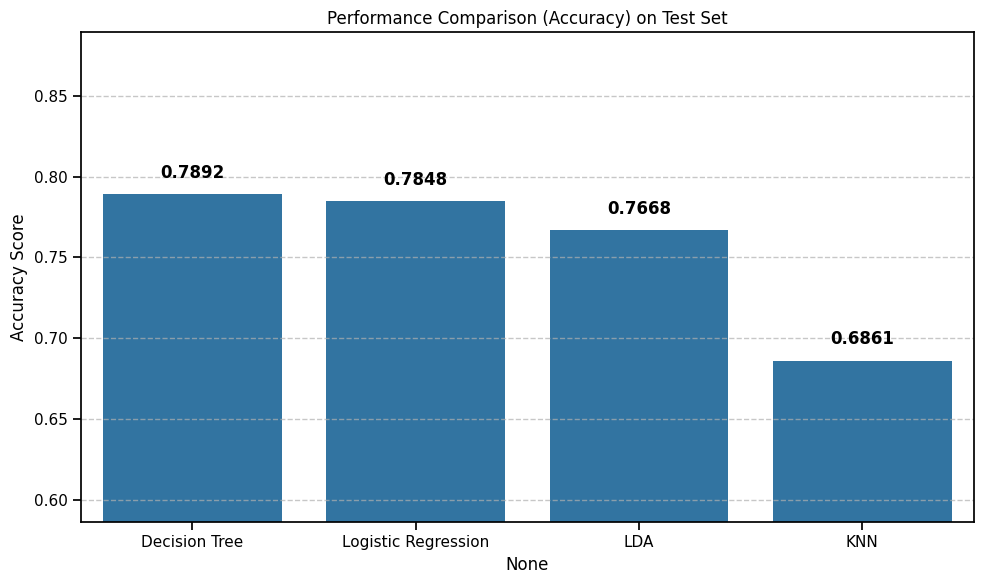

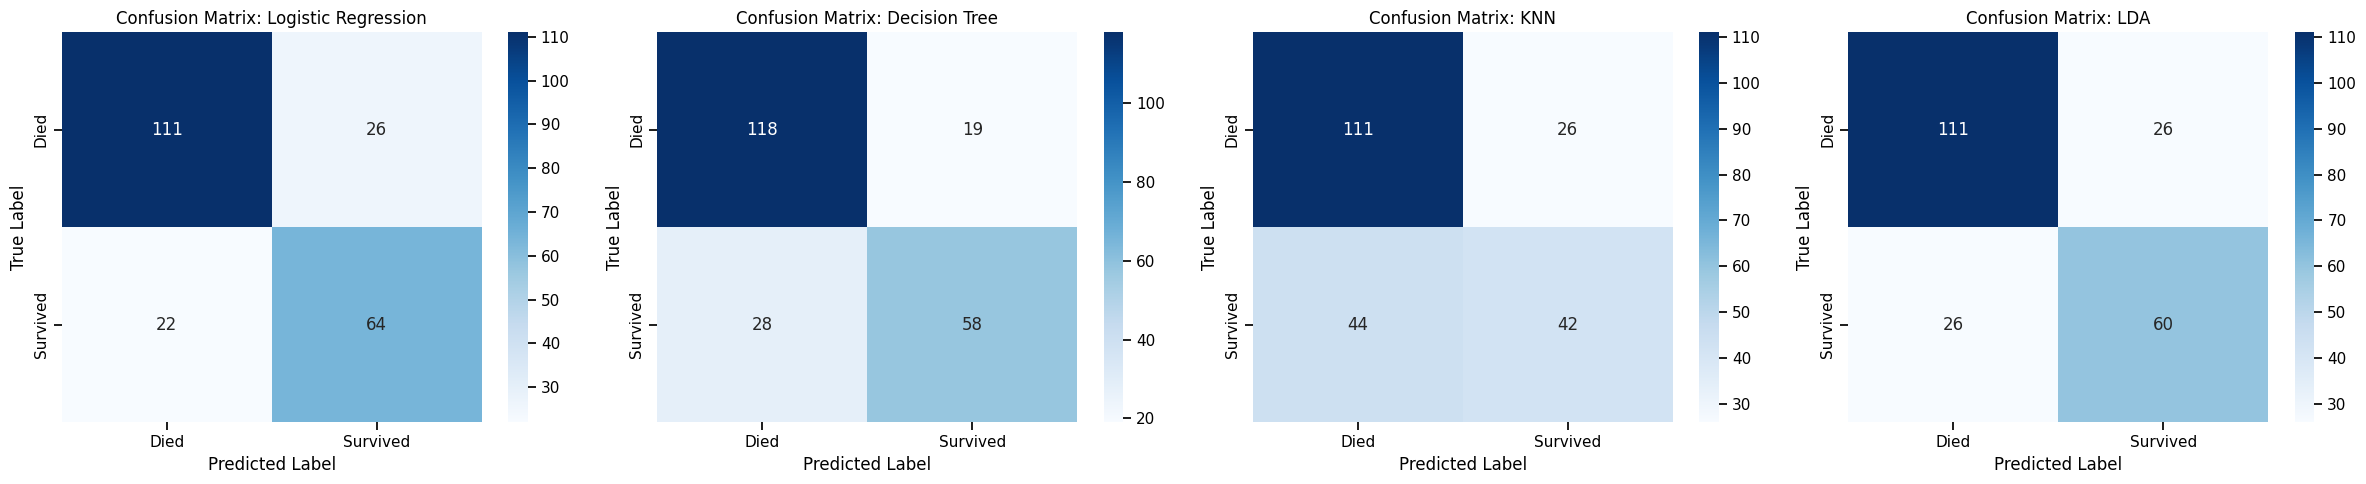

In [ ]:
# ---- Build models (use your tuned/best estimators if you already have them) ----

lda_baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())
])

models_to_run = [
    ("Logistic Regression", best_lr),
    ("Decision Tree", best_dt),
    ("KNN", best_knn),
    ("LDA", best_lda)
]

results = []
for name, model in models_to_run:
    r = evaluate(
        name=name,
        model=model,
        X_train=X_train_final,
        y_train=y_train,
        X_test=X_test_final,
        y_test=y_test,
        cv=cv
    )
    results.append(r)

# Quick table of results
pd.DataFrame([{
    "Model": r["name"],
    "CV mean acc": r["cv_mean"],
    "CV std": r["cv_std"],
    "Test acc": r["test_acc"],
    "Test MSE": r["test_mse"]
} for r in results]).sort_values("Test acc", ascending=False)

plot_accuracy_bar(results)
plot_confusion_matrices(results)


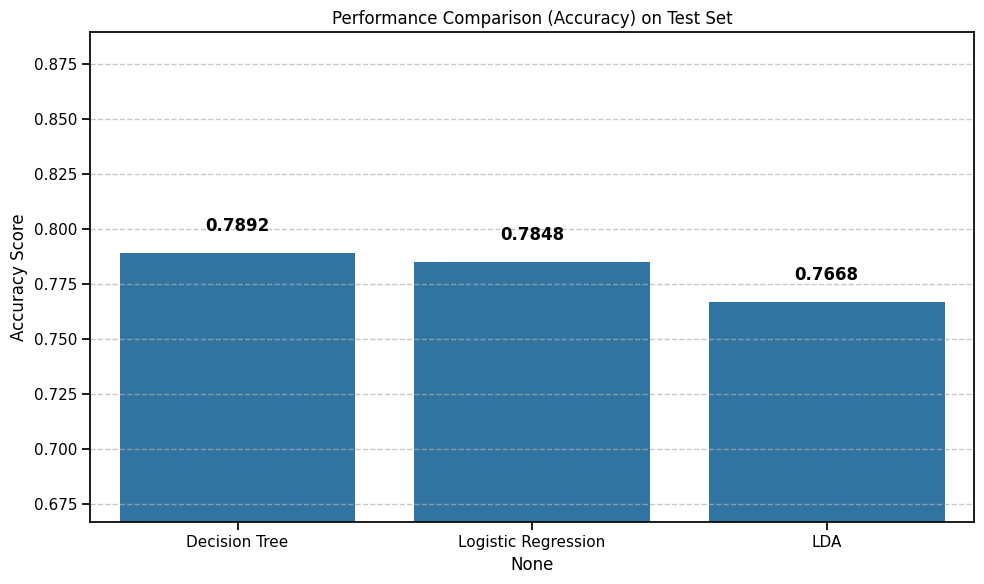

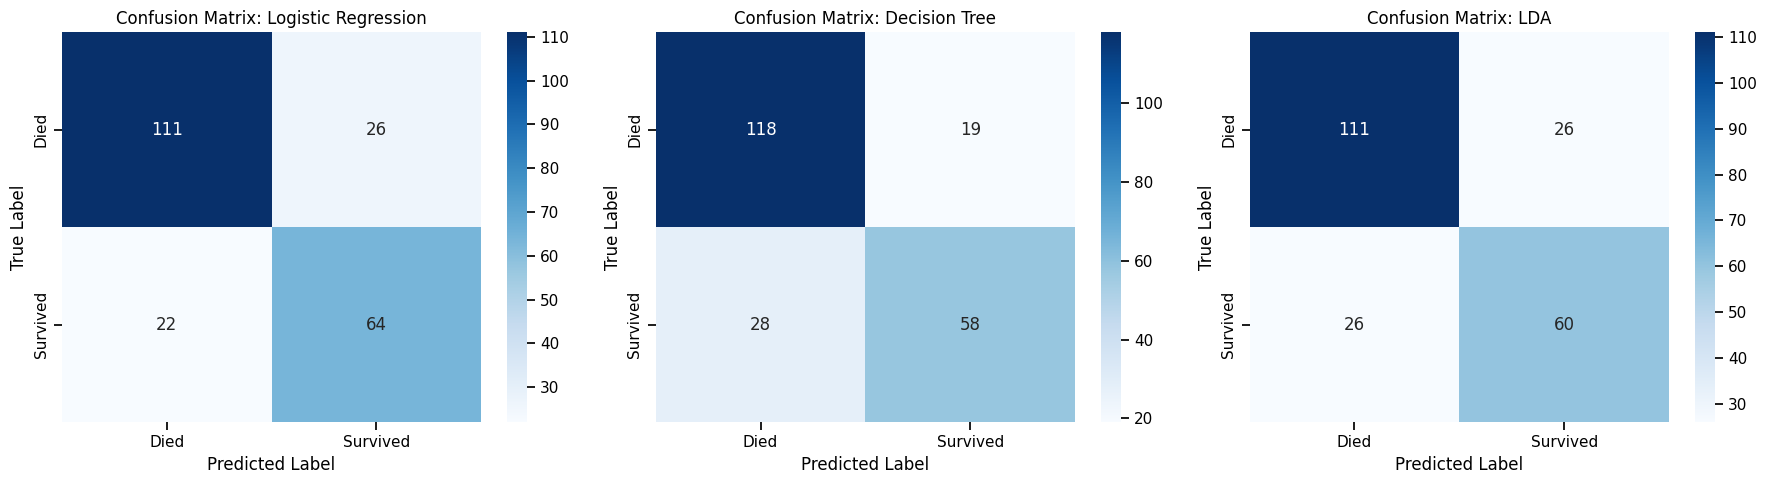

In [58]:
resilts_no_knn = [r for r in results if r["name"] != "KNN"]

plot_accuracy_bar(resilts_no_knn)
plot_confusion_matrices(resilts_no_knn)